In [ ]:
#|default_exp distributed.forecast

In [ ]:
#|hide
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
import warnings

from nbdev import show_doc
from sklearn import set_config

set_config(display='text')
warnings.filterwarnings('ignore')

# Distributed forecast

> Distributed pipeline encapsulation

**This interface is only tested on Linux**

In [ ]:
#|export
import reprlib
from typing import Callable, List, Optional

import dask.dataframe as dd
import pandas as pd
from dask.distributed import Client, default_client

from mlforecast.core import TimeSeries
from mlforecast.forecast import Forecast
from mlforecast.distributed.core import DistributedTimeSeries

In [ ]:
#|export
class DistributedForecast(Forecast):
    """Distributed pipeline encapsulation."""
    
    def __init__(self, models, ts: TimeSeries, client: Optional[Client] = None):
        if not isinstance(models, list):
            models = [models]
        self.models = models
        self.client = client or default_client()
        self.dts = DistributedTimeSeries(ts, self.client)
        for model in self.models:
            model.client = self.client
        
    def __repr__(self) -> str:
        return f'DistributedForecast(models={reprlib.repr(self.models)}, dts={self.dts})'

    def preprocess(
        self,
        data: dd.DataFrame,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,        
    ) -> dd.DataFrame:
        """Computes the transformations on each partition of `data`.

        Saves the resulting `TimeSeries` objects as well as the divisions in `data` for the forecasting step.
        Returns a dask dataframe with the computed features."""
        return self.dts.fit_transform(data, static_features, dropna, keep_last_n)

    def fit(
        self,
        data: dd.DataFrame,
        static_features: Optional[List[str]] = None,
        dropna: bool = True,
        keep_last_n: Optional[int] = None,            
        **fit_kwargs,
    ) -> 'DistributedForecast':
        """Perform the preprocessing and fit the model."""
        train_ddf = self.preprocess(data, static_features, dropna, keep_last_n)
        X, y = train_ddf.drop(columns=['ds', 'y']), train_ddf.y
        for model in self.models:
            model.fit(X, y, **fit_kwargs)
        return self

    def predict(
        self,
        horizon: int,
        dynamic_dfs: Optional[List[pd.DataFrame]] = None,
        predict_fn: Optional[Callable] = None,
        **predict_fn_kwargs,
    ) -> dd.DataFrame:
        """Compute the predictions for the next `horizon` steps.
        
        `predict_fn(model, new_x, features_order, **predict_fn_kwargs)` is called in every timestep, where:
        `model` is the trained model.
        `new_x` is a dataframe with the same format as the input plus the computed features.
        `features_order` is the list of column names that were used in the training step.
        """
        return self.dts.predict(
            [m.model_ for m in self.models], horizon, dynamic_dfs, predict_fn, **predict_fn_kwargs
        )

The `DistributedForecast` class is a high level abstraction that encapsulates all the steps in the pipeline (preprocessing, fitting the model and computing predictions) and applies them in a distributed way.

## Example
This shows an example with simulated data, for a real world example in a remote cluster you can check the [M5 distributed example](https://www.kaggle.com/lemuz90/m5-mlforecast-distributed).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from mlforecast.utils import backtest_splits, generate_daily_series, generate_prices_for_series
from mlforecast.distributed.models.lgb import LGBMForecast
from mlforecast.distributed.models.xgb import XGBForecast

The different things that you need to use `DistributedForecast` (as opposed to `Forecast`) are:
1. You need to set up a `dask.distributed.Client`. If this client is connected to a remote cluster then the process will run there.
2. Your data needs to be a `dask.dataframe.DataFrame`.
3. You need to use a model that implements distributed training.

### Client setup

Here we define a client that connects to a `dask.distributed.LocalCluster`, however it could be any other kind of cluster.

In [ ]:
client = Client(n_workers=2, threads_per_worker=1)

### Data setup

The data is given as a `dask.dataframe.DataFrame`, you need to make sure that each time serie is only in one partition and it is recommended that you have as many partitions as you have workers. If you have more partitions than workers make sure to set `num_threads=1` in `TimeSeries` to avoid having nested parallelism.

The required input format is the same as for `Forecast`, except that it's a `dask.dataframe.DataFrame` instead of a `pandas.Dataframe`.

In [ ]:
series = generate_daily_series(100, n_static_features=2, equal_ends=True, static_as_categorical=False)
partitioned_series = dd.from_pandas(series, npartitions=10)
partitioned_series

,ds,y,static_0,static_1
npartitions=10,,,,
id_00,datetime64[ns],float64,int64,int64
id_10,...,...,...,...
...,...,...,...,...
id_89,...,...,...,...
id_99,...,...,...,...


### Models
In order to perform distributed forecasting, we need to use a model that is able to train in a distributed way using `dask`. The current implementations are in `LGBMForecast` and `XGBForecast` which are just wrappers around `lightgbm.dask.DaskLGBMRegressor` and `xgboost.dask.DaskXGBRegressor` that add a `model_` property to get the trained model from them and send it to every worker to perform the predictions step.

In [ ]:
models = [LGBMForecast(), XGBForecast()]

### TimeSeries

As in the local version (`Forecast`) a `TimeSeries` object is required.

In [ ]:
ts = TimeSeries(
    freq='D',
    lags=[7],
    lag_transforms={
        1: [expanding_mean],
        7: [(rolling_mean, 14)]
    },
    date_features=['dayofweek', 'month'],
    num_threads=1,    
)
ts

TimeSeries(freq=<Day>, transforms=['lag-7', 'expanding_mean_lag-1', 'rolling_mean...indow_size-14'], date_features=['dayofweek', 'month'], num_threads=1)

Here where we say that:
* Our series have daily frequency.
* We want to use lag 7 as a feature
* We want the lag transformations to be:
   * expanding mean of the lag 1
   * rolling mean of the lag 7 over a window of size 14
* We want to use dayofweek and month as date features.
* We want to perform the preprocessing and the forecasting steps using 1 thread, because we have 10 partitions and 2 workers.

### Training
Once we have our model and time series we instantiate a `DistributedForecast` with them.

In [ ]:
fcst = DistributedForecast(models, ts)

From this point we have two options:

1. Preprocess the data and fit our model using all of it.
2. Preprocess the data and get it back as a dataframe to do some custom splitting or adding additional features. And then training the model.

#### 1. Using all the data

In [ ]:
show_doc(DistributedForecast.fit)

---

### DistributedForecast.fit

>      DistributedForecast.fit (data:dask.dataframe.core.DataFrame,
>                               static_features:Optional[List[str]]=None,
>                               dropna:bool=True,
>                               keep_last_n:Optional[int]=None, **fit_kwargs)

Perform the preprocessing and fit the model.

Calling `.fit` on our data computes the features independently for each partition and performs distributed training.

In [ ]:
fcst.fit(partitioned_series)

Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 33427...
[LightGBM] [Info] Binding port 33427 succeeded
[LightGBM] [Warning] Connecting to rank 1 failed, waiting for 200 milliseconds
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 1 failed, waiting for 260 milliseconds
[LightGBM] [Info] Trying to bind port 57853...
[LightGBM] [Info] Binding port 57853 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Warning] [LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:09:56] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 0
[21:09:56] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 1


DistributedForecast(models=[LGBMForecast(...earner='data'), XGBForecast(b..._parameters=1)], dts=DistributedTimeSeries(freq=<Day>, transforms=['lag-7', 'expanding_mean_lag-1', 'rolling_mean...indow_size-14'], date_features=['dayofweek', 'month'], num_threads=1))

#### 2. Preprocess and train

If we only want to perform the preprocessing step we call `.preprocess` on our data.

In [ ]:
show_doc(DistributedForecast.preprocess)

---

### DistributedForecast.preprocess

>      DistributedForecast.preprocess (data:dask.dataframe.core.DataFrame,
>                                      static_features:Optional[List[str]]=None,
>                                      dropna:bool=True,
>                                      keep_last_n:Optional[int]=None)

Computes the transformations on each partition of `data`.

Saves the resulting `TimeSeries` objects as well as the divisions in `data` for the forecasting step.
Returns a dask dataframe with the computed features.

In [ ]:
features_ddf = fcst.preprocess(partitioned_series)
features_ddf.head()

,ds,y,static_0,static_1,lag-7,expanding_mean_lag-1,rolling_mean_lag-7_window_size-14,dayofweek,month
unique_id,,,,,,,,,
id_00,2000-10-25,497.668437,79,45,506.946385,250.013666,263.200596,2,10
id_00,2000-10-26,39.183469,79,45,38.877800,261.806750,263.133868,3,10
id_00,2000-10-27,94.377779,79,45,115.127739,251.687510,263.980563,4,10
id_00,2000-10-28,179.235741,79,45,180.384975,244.847957,264.252723,5,10
id_00,2000-10-29,267.546447,79,45,242.228588,242.114114,263.055629,6,10


This is useful if we want to inspect the data the model will be trained, adding additional features or performing some custom train-valid split. Here we perform a 80-20 split.

In [ ]:
rng = np.random.RandomState(0)

def mask_as_series(df):
    return pd.Series(rng.rand(df.shape[0]) < 0.8, index=df.index)

train_mask = features_ddf.map_partitions(mask_as_series)
train, valid = features_ddf[train_mask], features_ddf[~train_mask]
X_train, y_train = train.drop(columns=['ds', 'y']), train.y
X_valid, y_valid = valid.drop(columns=['ds', 'y']), valid.y

If we do this we must "manually" train our model calling `DistributedForecast.model.fit`.

In [ ]:
fcst.models[0].fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_metric='rmse',
    verbose=0,
)

Finding random open ports for workers
[LightGBM] [Info] Listening...
[LightGBM] [Info] Listening...


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMForecast(client=<Client: 'tcp://127.0.0.1:37977' processes=2 threads=2, memory=12.42 GiB>,
             num_threads=1, time_out=120, tree_learner='data')

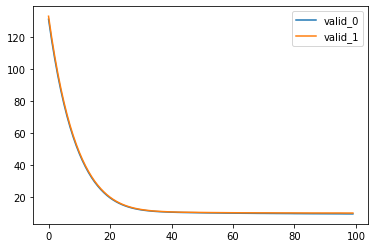

In [ ]:
for lab in fcst.models[0].evals_result_.keys():
    plt.plot(fcst.models[0].evals_result_[lab]['rmse'], label=lab)
plt.legend();

### Forecasting

In [ ]:
show_doc(DistributedForecast.predict)

---

### DistributedForecast.predict

>      DistributedForecast.predict (horizon:int,
>                                   dynamic_dfs:Optional[List[pandas.core.frame.
>                                   DataFrame]]=None,
>                                   predict_fn:Optional[Callable]=None,
>                                   **predict_fn_kwargs)

Compute the predictions for the next `horizon` steps.

`predict_fn(model, new_x, features_order, **predict_fn_kwargs)` is called in every timestep, where:
`model` is the trained model.
`new_x` is a dataframe with the same format as the input plus the computed features.
`features_order` is the list of column names that were used in the training step.

Once we have our fitted model we can compute the predictions for the next 7 timesteps.

In [ ]:
preds = fcst.predict(7)
preds

,ds,LGBMRegressor,XGBRegressor
npartitions=10,,,
id_00,datetime64[ns],float64,float32
id_10,...,...,...
...,...,...,...
id_89,...,...,...
id_99,...,...,...


In [ ]:
#|hide
preds = preds.compute()
preds2 = fcst.predict(7).compute()
pd.testing.assert_frame_equal(preds, preds2)

#### Dynamic features

By default the predict method repeats the static features and updates the transformations and the date features. If you have dynamic features like prices or a calendar with holidays you can pass them as a list to the `dynamic_dfs` argument of `Forecast.predict`, which will call `pd.DataFrame.merge` on each of them in order.

Here's an example:

Suppose that we have a `product_id` column and we have a catalog for prices based on that `product_id` and the date.

In [ ]:
dynamic_series = series.rename(columns={'static_1': 'product_id'})
prices_catalog = generate_prices_for_series(dynamic_series)
prices_catalog

,ds,product_id,price
0,2000-06-09,1,0.548814
1,2000-06-10,1,0.715189
2,2000-06-11,1,0.602763
3,2000-06-12,1,0.544883
4,2000-06-13,1,0.423655
...,...,...,...
20180,2001-05-17,99,0.223520
20181,2001-05-18,99,0.446104
20182,2001-05-19,99,0.044783
20183,2001-05-20,99,0.483216


And you have already merged these prices into your series dataframe.

In [ ]:
dynamic_series = partitioned_series.rename(columns={'static_1': 'product_id'})
dynamic_series = dynamic_series.reset_index()
series_with_prices = dynamic_series.merge(prices_catalog, how='left')
series_with_prices = series_with_prices.set_index('unique_id', sorted=True)
series_with_prices.head()

,ds,y,static_0,product_id,price
unique_id,,,,,
id_00,2000-10-05,39.811983,79,45,0.570826
id_00,2000-10-06,103.274013,79,45,0.260562
id_00,2000-10-07,176.574744,79,45,0.274048
id_00,2000-10-08,258.987900,79,45,0.433878
id_00,2000-10-09,344.940404,79,45,0.653738


This dataframe will be passed to `DistributedForecast.fit` (or `DistributedForecast.preprocess`), however since the price is dynamic we have to tell that method that only `static_0` and `product_id` are static and we'll have to update `price` in every timestep, which basically involves merging the updated features with the prices catalog.

In [ ]:
fcst = DistributedForecast(XGBForecast(), ts)
fcst.fit(series_with_prices, static_features=['static_0', 'product_id'])

/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:00] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 0
[21:10:00] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 1


DistributedForecast(models=[XGBForecast(b..._parameters=1)], dts=DistributedTimeSeries(freq=<Day>, transforms=['lag-7', 'expanding_mean_lag-1', 'rolling_mean...indow_size-14'], date_features=['dayofweek', 'month'], num_threads=1))

So in order to update the price in each timestep we just call `DistributedForecast.predict` with our forecast horizon and pass the prices catalog as a dynamic dataframe.

In [ ]:
preds = fcst.predict(7, dynamic_dfs=[prices_catalog])
preds.compute()

,ds,XGBRegressor
unique_id,,
id_00,2001-05-15,422.469238
id_00,2001-05-16,505.116028
id_00,2001-05-17,17.797546
id_00,2001-05-18,100.406456
id_00,2001-05-19,181.216293
...,...,...
id_99,2001-05-17,439.114716
id_99,2001-05-18,19.992741
id_99,2001-05-19,89.852440


#### Custom predictions

If you want to do something like scaling the predictions you can define a function and pass it to `DistributedForecast.predict` as described in <a href="/mlforecast/forecast.html#Custom-predictions">Custom predictions</a>.

### Backtesting

If we would like to know how good our forecast will be for a specific model and set of features then we can perform backtesting. What backtesting does is take our data and split it in two parts, where the first part is used for training and the second one for validation. Since the data is time dependant we usually take the last *x* observations from our data as the validation set.

This process is implemented in `DistributedForecast.backtest`, which takes our data and performs the process described above for `n_windows` times where each window is of size `window_size`. For example, if we have 100 samples and we want to perform 2 backtests each of size 14, the splits will be as follows:

1. Train: 1 to 72. Validation: 73 to 86.
2. Train: 1 to 86. Validation: 87 to 100.

In [ ]:
show_doc(DistributedForecast.backtest)

---

### Forecast.backtest

>      Forecast.backtest (data, n_windows:int, window_size:int,
>                         static_features:Optional[List[str]]=None,
>                         dropna:bool=True, keep_last_n:Optional[int]=None, dyna
>                         mic_dfs:Optional[List[pandas.core.frame.DataFrame]]=No
>                         ne, predict_fn:Optional[Callable]=None,
>                         **predict_fn_kwargs)

Creates `n_windows` splits of `window_size` from `data`, trains the model
on the training set, predicts the window and merges the actuals and the predictions
in a dataframe.

Returns a generator to the dataframes containing the datestamps, actual values
and predictions.

In [ ]:
n_windows = 2
window_size = 14

fcst = DistributedForecast(models, ts)
backtest_results = fcst.backtest(partitioned_series, n_windows, window_size)

This returns a generator that yields the results of each window one at a time.

In [ ]:
window1_result = next(backtest_results)
window1_result

Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 40447...
[LightGBM] [Info] Binding port 40447 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Trying to bind port 45709...
[LightGBM] [Info] Binding port 45709 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:02] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 0
[21:10:02] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 1


,ds,y,LGBMRegressor,XGBRegressor
npartitions=10,,,,
id_00,datetime64[ns],float64,float64,float32
id_10,...,...,...,...
...,...,...,...,...
id_89,...,...,...,...
id_99,...,...,...,...


In [ ]:
window2_result = next(backtest_results)
results = pd.concat([window1_result.compute(), window2_result.compute()])

Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 59465...
[LightGBM] [Info] Binding port 59465 succeeded
[LightGBM] [Warning] Connecting to rank 1 failed, waiting for 200 milliseconds
[LightGBM] [Info] Listening...
[LightGBM] [Info] Trying to bind port 37827...
[LightGBM] [Info] Binding port 37827 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:03] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 0
[21:10:03] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 1


We can aggregate these by date to get a rough estimate of how our model is doing.

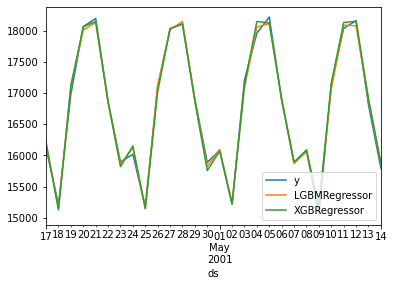

In [ ]:
agg_results = results.groupby('ds').sum()
agg_results.plot();

We can include some more context by using the values in the training set.

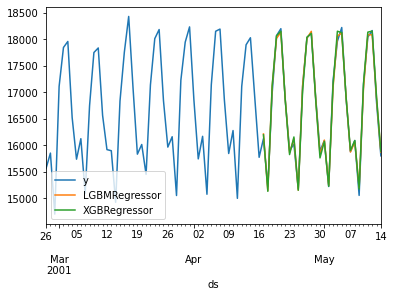

In [ ]:
history = series[series.ds < agg_results.index.min()]
agg_history = history.groupby('ds')[['y']].sum().tail(50)
agg_history.append(agg_results).plot();

Note that since the backtest results are returned as a generator we can also compute a single statistic on them and not keep the whole results in memory.

In [ ]:
def mse_from_dask_dataframe(ddf):
    mses = {}
    for model_name in ddf.columns.drop(['ds', 'y']):
        mses[model_name] = (ddf['y'] - ddf[model_name]).pow(2).mean()
    return client.gather(client.compute(mses))

In [ ]:
fcst = DistributedForecast(models, ts)
backtest_results = fcst.backtest(partitioned_series, n_windows, window_size)
losses = [mse_from_dask_dataframe(res) for res in backtest_results]

Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 48237...
[LightGBM] [Info] Binding port 48237 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Warning] Connecting to rank 1 failed, waiting for 200 milliseconds
[LightGBM] [Info] Trying to bind port 40797...
[LightGBM] [Info] Binding port 40797 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:06] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 0
[21:10:06] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 1


Finding random open ports for workers
[LightGBM] [Info] Trying to bind port 34641...
[LightGBM] [Info] Binding port 34641 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Trying to bind port 41073...
[LightGBM] [Info] Binding port 41073 succeeded
[LightGBM] [Info] Listening...
[LightGBM] [Info] Connected to rank 1
[LightGBM] [Info] Local rank: 0, total number of machines: 2
[LightGBM] [Info] Connected to rank 0
[LightGBM] [Info] Local rank: 1, total number of machines: 2
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1


/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:07] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 0
[21:10:07] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 1


In [ ]:

[{k: np.round(v) for k, v in loss.items()} for loss in losses]

[{'LGBMRegressor': 90.0, 'XGBRegressor': 88.0},
 {'LGBMRegressor': 94.0, 'XGBRegressor': 90.0}]

In [ ]:
#|hide
model = XGBForecast()
ts = TimeSeries(lags=[7, 14])
fcst = DistributedForecast(model, ts)
backtest_results = [res.compute() for res in fcst.backtest(partitioned_series, n_windows, window_size)]
manual_results = []
for train, valid in backtest_splits(partitioned_series, n_windows, window_size):
    model = XGBForecast()
    ts = TimeSeries(lags=[7, 14], num_threads=1)
    fcst = DistributedForecast(model, ts).fit(train)
    pred = fcst.predict(window_size).compute()
    res = valid[['ds', 'y']].compute()
    manual_results.append(res.merge(pred, on=['unique_id', 'ds'], how='left'))
backtest_results = pd.concat(backtest_results)
manual_results = pd.concat(manual_results)
pd.testing.assert_frame_equal(backtest_results, manual_results)

/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
[21:10:09] task [xgboost.dask]:tcp://127.0.0.1:43965 got new rank 0
[21:10:09] task [xgboost.dask]:tcp://127.0.0.1:44089 got new rank 1
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  warnings.warn(
/home/jmoralez/miniforge3/envs/mlforecast/lib/python3.10/site-packages/distributed/worker_state_machine.py:3468: FutureWarning: The `Worker.nthreads` attribute has been moved to `Worker.state.nthreads`
  war

In [ ]:
client.close()